In [5]:
import time
import pinocchio as pin
import numpy as np
import meshcat
from pinocchio.visualize import MeshcatVisualizer
from pathlib import Path

In [6]:
# model_dir = Path("./models").expanduser().resolve()
# urdf_file = model_dir / "kinova_gen3_7dof.urdf"
# robot = pin.robot_wrapper.RobotWrapper.BuildFromURDF(
#     urdf_file.as_posix(), model_dir.as_posix(), None
# )
# print([j for j in robot.model.joints])
# TOOL_FRAME_NAME = 'tool_frame'

In [7]:
model_dir = Path("./models").expanduser().resolve()
urdf_file = model_dir / "franka.urdf"
robot = pin.robot_wrapper.RobotWrapper.BuildFromURDF(
    urdf_file.as_posix(), model_dir.as_posix(), None
)
robot = robot.buildReducedRobot(list_of_joints_to_lock=[8, 9],
                                reference_configuration=robot.q0)
print([j for j in robot.model.joints])
TOOL_FRAME_NAME = 'panda_hand'

[JointModelRX
  index: 18446744073709551615
  index q: -1
  index v: -1
  nq: 1
  nv: 1
, JointModelRZ
  index: 1
  index q: 0
  index v: 0
  nq: 1
  nv: 1
, JointModelRZ
  index: 2
  index q: 1
  index v: 1
  nq: 1
  nv: 1
, JointModelRZ
  index: 3
  index q: 2
  index v: 2
  nq: 1
  nv: 1
, JointModelRZ
  index: 4
  index q: 3
  index v: 3
  nq: 1
  nv: 1
, JointModelRZ
  index: 5
  index q: 4
  index v: 4
  nq: 1
  nv: 1
, JointModelRZ
  index: 6
  index q: 5
  index v: 5
  nq: 1
  nv: 1
, JointModelRZ
  index: 7
  index q: 6
  index v: 6
  nq: 1
  nv: 1
]


In [9]:
viz = MeshcatVisualizer(model=robot.model, collision_model=robot.collision_model, visual_model=robot.visual_model)
viz.initViewer(loadModel=True)
viz.display(robot.q0)
hasattr(viz.viewer, 'jupyter_cell') and viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [10]:
# oMgoal = pin.SE3(pin.Quaternion(-0.5, 0.58, -0.39, 0.52).normalized().matrix(),
#                 np.array([0.4, 0., .5]))
# viz.addBox('goal', [.1,.1,.1], [ .1,.1,.5, .6] )
# viz.applyConfiguration('goal',oMgoal)

In [11]:
def extract_reduced_q(q, model):
    ret = []
    for j in model.joints[1:]:
        idx = j.idx_q
        if 'UB' in j.shortname():
            ret.append(np.arctan2(q[idx+1], q[idx]))
        else:
            ret.append(q[idx])
    return np.array(ret)

def expand_reduced_q(q, model):
    ret = []
    for (joint, angle) in zip(model.joints[1:], q):
        if 'UB' in joint.shortname():
            ret.append(np.cos(angle))
            ret.append(np.sin(angle))
        else:
            ret.append(angle)
    return np.array(ret)

q0_reduced = extract_reduced_q(robot.q0, robot.model)
assert (expand_reduced_q(q0_reduced, robot.model) - robot.q0) @ (expand_reduced_q(q0_reduced, robot.model) - robot.q0) < 1e-6

In [12]:
def computed_torque_control(robot, q_ref_reduced, q, v):   
    K = 32 * np.eye(robot.model.nv)
    B = 32 * np.eye(robot.model.nv)
    q_reduced = extract_reduced_q(q, robot.model)
    M = pin.crba(robot.model, robot.data, q)
    b = pin.rnea(robot.model, robot.data, q, v, np.zeros(robot.model.nv))
    y = q_reduced - q_ref_reduced
    dy = v
    tau = b - M @ K @ y - M @ B @ dy
    return tau

def compute_adj(Tr: pin.SE3):
    return np.bmat([
        [Tr.rotation, np.zeros([3, 3])],
        [pin.skew(Tr.translation) @ Tr.rotation, Tr.rotation]
    ])

def impedance_control(robot, q, v, oMgoal: pin.SE3, Vd, oMgoal_next, Vd_next, dt):
    K = 1000 * np.eye(6)
    D = 500 * np.eye(6)
    
    pin.framesForwardKinematics(robot.model, robot.data, q)
#     pin.computeForwardKinematicsDerivatives(robot.model, robot.data, q, v,)
    idx_tool = robot.model.getFrameId(TOOL_FRAME_NAME)
    M = pin.crba(robot.model, robot.data, q)
    b = pin.rnea(robot.model, robot.data, q, v, np.zeros(robot.model.nv))
    
    Jb = pin.computeFrameJacobian(robot.model, robot.data, q, idx_tool, pin.LOCAL)
    # task space mass
    Lambda = np.linalg.inv(Jb @ np.linalg.inv(M) @ Jb.T)
    assert Lambda.shape == (6,6)
    JbT_ginv = (np.linalg.inv(M) @ Jb.T @ Lambda).T
    dJb = pin.frameJacobianTimeVariation(robot.model, robot.data, q, v, idx_tool, pin.LOCAL)
    eta = JbT_ginv @ b - Lambda @ dJb @ v
    
    # Task space control wrench
    eeMgoal = robot.data.oMf[idx_tool].inverse() * oMgoal
    eeMgoal_next = robot.data.oMf[idx_tool].inverse() * oMgoal_next
    
    Vb = Jb @ v
    Ve = compute_adj(eeMgoal) @ Vd - Vb
    Ve = np.asarray(Ve).flatten()
    
    dVd = (compute_adj(eeMgoal) @ Vd - compute_adj(eeMgoal_next) @ Vd_next) / dt
    dVd = np.asarray(dVd).flatten()
    
    D @ Ve
    f_c = Lambda @ (K @ pin.log(eeMgoal).np + D @ Ve + dVd) + eta
   
    
    # Null space damping
    tau_0 = -10 * M @ v
    
    assert (Jb.T @ JbT_ginv).shape == (7, 7)
    tau = Jb.T @ f_c + (np.eye(robot.model.nv) - Jb.T @ JbT_ginv) @ (tau_0 + b)
    return tau


In [14]:
acceleration = []
position = []
velocity = []
torque = []
duration = []
comp_time = []
ee_v_y = []
ee_p_y = []
ee_p_yd = []


## Kinova
# qd_reduced = np.array([ 0.18350167,  0.93813782, -0.30662305,  1.52665323,  0.22413282, -0.87752042,  1.87121915])
# qd = expand_reduced_q(qd_reduced, robot.model)

## Franka
qd = np.array([ 0.05312035,  0.55492166, -0.06379121, -1.6937397 ,  2.86171527, 2.41700262, -0.75383668])


viz.display(qd)
q = np.array(qd)
v = np.zeros(robot.model.nv)
a = np.zeros(robot.model.nv)

dt = 1e-3  # control frequency
T = 2

def get_desired_trajectory_points(t):
    half_T = 0.5
    T = half_T * 2
    l = 0.75
    
    def pos(t):
        return 0.5 * l * np.sin(2 * np.pi * t / T)
    
    def vel(t):
        return l * np.cos(2 * np.pi * t / T) * np.pi / T
    
    def oMgoal_at_t(t):
        oMgoal = pin.SE3(pin.Quaternion(-0.5, 0.58, -0.39, 0.52).normalized().matrix(),
                                  np.array([0.7, pos(t), .3]))
        return oMgoal
    
    def vd_at_t(t):
        o_v = np.array([0, vel(t), 0])
        oMgoal = oMgoal_at_t(t)
        goal_v = oMgoal.inverse().rotation @ o_v
        return pin.Motion(goal_v, np.zeros(3))
    
    return oMgoal_at_t(t), vd_at_t(t), oMgoal_at_t(t + dt), vd_at_t(t + dt)
    

for i in range(int(T/dt)):
    t = i*dt
    
    position.append(q)
    duration.append(t)
    
    M = pin.crba(robot.model, robot.data, q)
    b = pin.rnea(robot.model, robot.data, q, v, np.zeros(robot.model.nv))
    
    oMgoal, Vd, oMgoal_next, Vd_next = get_desired_trajectory_points(t)
    t_c_start = time.time()
    u = impedance_control(robot, q, v, oMgoal, Vd, oMgoal_next, Vd_next, dt)
    comp_time.append(time.time() - t_c_start)
#     u = computed_torque_control(robot, qd_reduced, q, v)
    
    torque.append(u)
    velocity.append(v)
    
    # get ee y velocity
    J_hack = pin.computeFrameJacobian(
        robot.model, robot.data, q, robot.model.getFrameId(TOOL_FRAME_NAME), pin.LOCAL_WORLD_ALIGNED
    )
    v_y = J_hack[1, :] @ v
    ee_v_y.append(v_y)
    ee_p_y.append(robot.data.oMf[robot.model.getFrameId(TOOL_FRAME_NAME)].translation[1])
    ee_p_yd.append(oMgoal.translation[1])

    a = np.linalg.pinv(M) @ (u - b)
    acceleration.append(a)
    v += a * dt
    q = pin.integrate(robot.model, q, v * dt)

    TDISP = 5e-3    # Display every 50ms
    if not i % int(TDISP/dt):  # Only display once in a while ...
        viz.display(q)
        time.sleep(TDISP)
    position.append(q)
    
acceleration = np.array(acceleration)
position = np.array(position)
velocity = np.array(velocity)
torque = np.array(torque)
duration = np.array(duration)
comp_time = np.array(comp_time)
ee_v_y = np.array(ee_v_y)
ee_p_y = np.array(ee_p_y)
ee_p_yd = np.array(ee_p_yd)

In [15]:
extract_reduced_q(position[-1, :], robot.model)

array([-0.39479985,  0.61353873,  0.44541803, -1.66577872,  2.82110162,
        2.47028115, -0.9923092 ])

In [16]:
from matplotlib import pyplot as plt

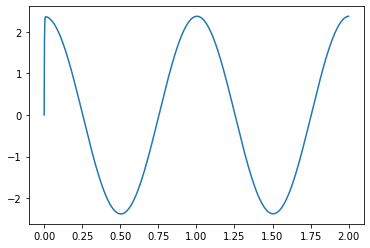

In [17]:
plt.plot(duration, ee_v_y)

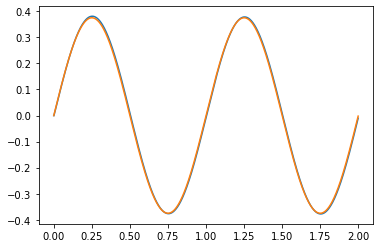

In [18]:
plt.plot(duration, ee_p_y, duration, ee_p_yd)

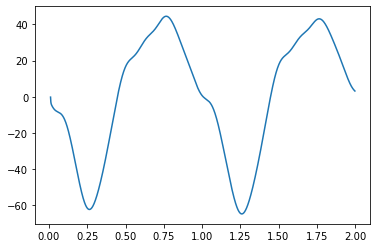

In [19]:
SKIP = 10
plt.plot(duration[SKIP:], torque[SKIP:, 0])

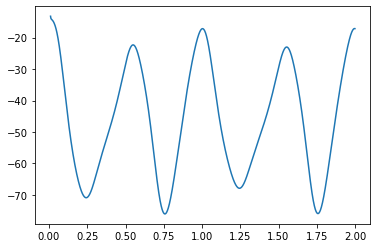

In [20]:
plt.plot(duration[SKIP:], torque[SKIP:, 1])

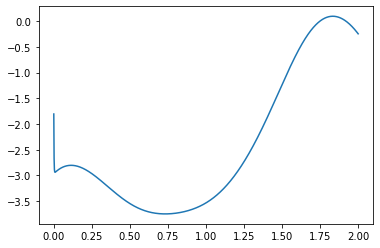

In [122]:
plt.plot(duration[SKIP:], torque[SKIP:, 2])

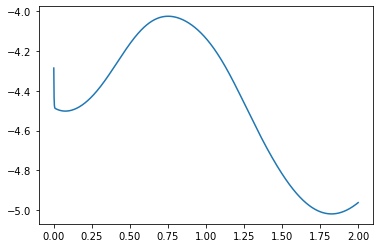

In [123]:
plt.plot(duration[SKIP:], torque[SKIP:, 3])

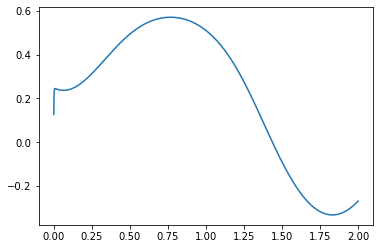

In [124]:
plt.plot(duration[SKIP:], torque[SKIP:, 4])

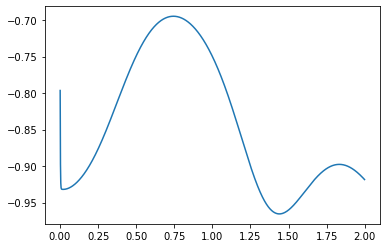

In [125]:
plt.plot(duration[SKIP:], torque[SKIP:, 5])

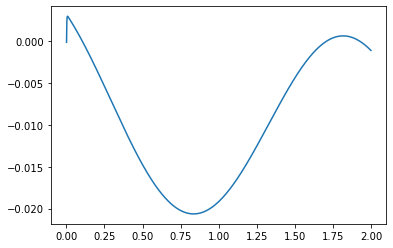

In [126]:
plt.plot(duration[SKIP:], torque[SKIP:, 6])

In [60]:
3.3 % 1

0.2999999999999998